In [47]:
import pandas as pd
import os
from data_preprocessing import preprocess_dataframe
from descriptor_calculation import descriptor_cal
# from descriptor_calculation import smiles_solvent_descriptors
from train_func import train_models
import shutil
import os
import deepchem as dc
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import os
import pickle
import matplotlib.pyplot as plt

In [48]:
PATH = "All Properties with Finguprints_3_LF1.csv"

df = pd.read_csv(PATH)
df.head()

,Smiles,Solvent,Lifetime (ns),Quantum yield,Fluorescent labeling
0,O=C([O-])c1ccccc1-c1c2ccc(=O)cc-2oc2cc([O-])ccc12,O,4.160,0.950,Yes
1,O=C([O-])c1ccccc1C1=c2cc3c4c(c2Oc2c1cc1c5c2CCC...,CO,4.590,1.000,Yes
2,O=C([O-])c1ccccc1-c1c2cc(Br)c(=O)c(Br)c-2oc2c(...,O,1.425,0.200,Yes
3,O=C([O-])c1ccccc1-c1c2cc(I)c(=O)c(I)c-2oc2c(I)...,O,0.115,0.020,Yes
4,O=C([O-])c1c(Cl)c(Cl)c(Cl)c(Cl)c1-c1c2cc(I)c(=...,O,0.095,0.018,Yes


In [49]:
df.shape

(22495, 5)

In [50]:
df.drop(df.index[df['Solvent'] == 'gas'], inplace = True)

In [51]:
df.shape

(22495, 5)

In [52]:
df.shape

(22495, 5)

In [53]:
# Select only Fluoroscent molecules, since solvents data is available for Fluroscent pnly
df = df.loc[df['Fluorescent labeling'] == 'Yes']
df.shape

(6095, 5)

### Calculate descriptors

In [54]:
def smiles_solvent_descriptors(df,desc,TARGET):
  try:
      dataset_original=df
      
      # morgan
      if desc == "Morgan fingerprints": 
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.CircularFingerprint(radius=3, size=1024)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)

          y = dataset_original[TARGET]

          return x, y
      # rdkit

      elif desc == 'Mordred descriptors':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.MordredDescriptors(ignore_3D = True)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'MACCSKeysFingerprint':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.MACCSKeysFingerprint()
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'RDKitDescriptors':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.RDKitDescriptors(use_fragment=True, ipc_avg=True)
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          x.replace([np.inf, -np.inf], np.nan, inplace=True)
          x.fillna(0, inplace=True)
          scaler = StandardScaler()
          x = pd.DataFrame(data=scaler.fit_transform(x))
          y = dataset_original[TARGET]

          return x, y

      elif desc == 'PubChemFingerprint':
          smiles = dataset_original['Smiles'].tolist()
          featurizer = dc.feat.PubChemFingerprint()
          discriptors = featurizer.featurize(smiles)
          smiles_desc = pd.DataFrame(data=discriptors)

          solvent = dataset_original['Solvent'].tolist()
          discriptors_solvent = featurizer.featurize(solvent)
          solvent_desc = pd.DataFrame(data=discriptors_solvent)

          x = pd.concat([smiles_desc, solvent_desc], axis=1)
          y = dataset_original[TARGET]

          return x, y

      else:
          pass

  except Exception as e:
      raise e


In [55]:
descriptor_list = ["Morgan fingerprints","MACCSKeysFingerprint","RDKitDescriptors"] 
TARGET = "Lifetime (ns)"

In [56]:
path_to_descriptors = "LambdaMaxDesc"

In [57]:
for descriptor in descriptor_list:
    # Call the descriptor_cal function to get X and Y
    X, Y = smiles_solvent_descriptors(df, descriptor,TARGET)
    
    # Create a folder for the descriptor if it doesn't exist
    folder_path = os.path.join(os.getcwd(),path_to_descriptors, f"{descriptor}")
    if not os.path.exists(folder_path):
        os.makedirs(folder_path)
    
    # Save the X and Y DataFrames to separate CSV files in the folder
    x_file_path = os.path.join(folder_path, 'X.csv')
    y_file_path = os.path.join(folder_path, 'Y.csv')
    X.to_csv(x_file_path, index=False)
    Y.to_csv(y_file_path, index=False)

    print(f"X and y saved for {descriptor}")
    print(f"descriptors shape: {X.shape}")

X and y saved for Morgan fingerprints
descriptors shape: (6095, 2048)
X and y saved for MACCSKeysFingerprint
descriptors shape: (6095, 334)
X and y saved for RDKitDescriptors
descriptors shape: (6095, 416)


### Train Models

In [58]:
def train_regression(X, y, PATH):
    # Split the data into training and testing sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    # Define a dictionary of regression models
    models = {
        'Ridge Regression': Ridge(),
        'Lasso Regression': Lasso(),
        'ElasticNet Regression': ElasticNet(),
        'Decision Tree Regression': DecisionTreeRegressor(),
        'Random Forest Regression': RandomForestRegressor(),
        'Support Vector Regression': SVR(),
        'K-Nearest Neighbors Regression': KNeighborsRegressor()
    }

    # Define a list of evaluation metrics to evaluate the models
    metrics = [mean_absolute_error, mean_squared_error, r2_score]

    # Create a results folder if it doesn't exist
    if not os.path.exists(PATH):
        os.makedirs(PATH)

    # Loop through each model, train it, and evaluate its performance
    for name, model in models.items():
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        results = {}
        for metric in metrics:
            metric_name = metric.__name__
            results[metric_name] = metric(y_test, y_pred)
        results_df = pd.DataFrame.from_dict(results, orient='index', columns=[name])

        # create path
        new_path= os.path.join(PATH,name)
        os.makedirs(new_path, exist_ok=True)

        # save scores
        results_df.to_csv(f'{PATH}/{name}/{name}.csv')

        # save models
        pickle.dump(model, open(f'{PATH}/{name}/{model}.pkl', 'wb'))

        # plot regression line with R-squared score
        y_test= y_test.squeeze()
        r2 = r2_score(y_test, y_pred)
        plt.scatter(y_test, y_pred)
        plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], '--', color='red') # regression line
        plt.xlabel('True Values')
        plt.ylabel('Predictions')
        plt.title(f'{name} (R-squared = {r2:.2f})')
        plt.savefig(f'{PATH}/{name}/{name}_scatter.png', dpi=300, bbox_inches='tight')
        plt.close()

In [46]:
# Define the path to the folder containing subfolders
path_to_descriptors = "LifetimeDesc"
results_folder = "LifetimeScores"
if os.path.exists(results_folder):
    shutil.rmtree(results_folder)


# Loop over each subfolder
for subfolder_name in os.listdir(path_to_descriptors):
    
    # Define the path to the X.csv and Y.csv files for the current subfolder
    path_to_X = os.path.join(path_to_descriptors, subfolder_name, "X.csv")
    path_to_Y = os.path.join(path_to_descriptors, subfolder_name, "Y.csv")
    
    # Load the X.csv and Y.csv files as dataframes
    X = pd.read_csv(path_to_X)
    Y = pd.read_csv(path_to_Y)
    
    # Call the train_models function with X, Y, and the current subfolder name as the PATH argument
    train_regression(X, Y, f"{results_folder}/{subfolder_name}")

C:\Users\26pde\AppData\Local\Temp\ipykernel_17864\3194391035.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\26pde\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
C:\Users\26pde\AppData\Local\Temp\ipykernel_17864\3194391035.py:25: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)
C:\Users\26pde\anaconda3\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using rave

AttributeError: 'NoneType' object has no attribute 'split'

### Plot results

In [30]:
for subfolder in os.listdir("LambdaMaxScores"):
        subfolder_path = os.path.join("LambdaMaxScores", subfolder)
        print(subfolder_path)

LambdaMaxScores\MACCSKeysFingerprint
LambdaMaxScores\Morgan fingerprints
LambdaMaxScores\RDKitDescriptors


In [95]:
for subfolder in os.listdir("/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint"):
        subfolder_path = os.path.join("/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint", subfolder)
        print(subfolder_path)

/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/Random Forest Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/Support Vector Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/ElasticNet Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/Lasso Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/Ridge Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/Decision Tree Regression
/Users/ganeshjadhav/Desktop/ML_Projects/MyProjects/Fluorescent_compound_prediction/LambdaMaxScores/MACCSKeysFingerprint/K-Nearest Neighbors Regressi

In [103]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

def plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT):
        
    # Define a list to store the accuracy values for each csv file
    accuracy_values = []

    # Loop through each subfolder in folder1
    for subfolder in os.listdir(SCORES_FOLDER):
        subfolder_path = os.path.join(SCORES_FOLDER, subfolder)

        for new_subfolder in os.listdir(subfolder_path):
            new_subfolder_path = os.path.join(subfolder_path, new_subfolder)
            # Loop through each csv file in the subfolder
            for csv_file in os.listdir(new_subfolder_path):
                if csv_file.endswith('.csv'):
                    csv_path = os.path.join(new_subfolder_path, csv_file)
                    
                    # Read the csv file into a pandas dataframe
                    df = pd.read_csv(csv_path, index_col=[0])
                    
                    # Extract the accuracy value from the dataframe and append it to the list
                    accuracy_value = df.loc[METRIC_TO_PLOT].values[0]
                    accuracy_values.append((subfolder, csv_file[:-4], accuracy_value)) # Remove the last 4 characters (i.e. ".csv") from the csv file name

    # Convert the accuracy values list to a pandas dataframe
    df_accuracy = pd.DataFrame(accuracy_values, columns=['Subfolder', 'CSV File', METRIC_TO_PLOT])

    # Pivot the dataframe to have Subfolder as the index, CSV File as the columns, and Accuracy as the values
    df_accuracy_pivot = df_accuracy.pivot(index='Subfolder', columns='CSV File', values=METRIC_TO_PLOT)

    # Create a plot of the accuracy values
    plt.figure(figsize=(10, 5))
    for csv_file in df_accuracy_pivot.columns:
        plt.plot(df_accuracy_pivot.index, df_accuracy_pivot[csv_file], label=csv_file[:]) # Remove the last 4 characters (i.e. ".csv") from the csv file name
    plt.xlabel('Subfolder')
    plt.ylabel(METRIC_TO_PLOT)
    plt.legend()

    # Get the current date and time and format it for the filename
    now = datetime.datetime.now()

    # Define the path and filename for the plot
    plot_path = f'{SCORES_FOLDER[:-6]}plots'
    if not os.path.exists(plot_path):
        os.makedirs(plot_path)
        
    plot_name = os.path.join(plot_path, METRIC_TO_PLOT)

    # Save the plot
    plt.savefig(plot_name)

    # Show the plot
    plt.show()

    print(f"Compairison plots saved at: {plot_path}")

    return df_accuracy


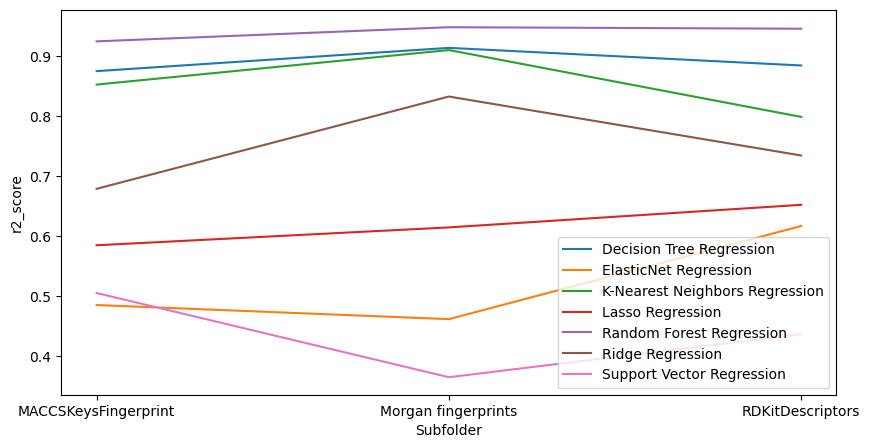

Compairison plots saved at: LambdaMaxplots


,Subfolder,CSV File,r2_score
0,MACCSKeysFingerprint,Random Forest Regression,0.925080
1,MACCSKeysFingerprint,Support Vector Regression,0.505404
2,MACCSKeysFingerprint,ElasticNet Regression,0.485338
3,MACCSKeysFingerprint,Lasso Regression,0.585026
4,MACCSKeysFingerprint,Ridge Regression,0.679154
5,MACCSKeysFingerprint,Decision Tree Regression,0.875415
6,MACCSKeysFingerprint,K-Nearest Neighbors Regression,0.853002
7,RDKitDescriptors,Random Forest Regression,0.946173
8,RDKitDescriptors,Support Vector Regression,0.436670
9,RDKitDescriptors,ElasticNet Regression,0.617163


In [110]:
SCORES_FOLDER = "LambdaMaxScores"
METRIC_TO_PLOT = "r2_score"
plot_metrics(SCORES_FOLDER,METRIC_TO_PLOT)